# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
from pymatgen.ext.matproj import MPRester
from sklearn.linear_model import LinearRegression
from IPython.display import display

#please import correct path if error occurs
initial_df = pd.read_csv(r'Python import (csv).csv')

**Data exploration**

In [4]:
def dataset_info(dataset):
    print(dataset.head())
    print(dataset.columns)
    print(dataset.describe())
    print(dataset.info())
    display(dataset)

**Data cleaning functions**

In [5]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [6]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
    return entropy_data

**Launching cleaning functions on datasets**

In [7]:
#Launching functions

initial_df = parse_Nan(initial_df)
entropy_data = column_cleaning(initial_df)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
#entropy_data['ΔGOOH*-ΔGOH*'] = entropy_data['ΔGOOH*'] - entropy_data['ΔGOH*']
#Slicing only data with values for required columns, then plotting dataset
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
dataset_info(entropy_data)
#print(entropy_data.describe())

  Catalyst Materials      Family  ΔGOH*  ΔGO*  ΔGOOH*  \
3             AgAlO3  Perovskite   2.18  4.63    5.10   
4             AgBiO3  Perovskite   1.09  3.37    4.23   
7             AgCoO3  Perovskite   1.59  3.28    4.66   
8             AgCrO3  Perovskite   0.83  2.36    4.26   
9             AgCuO3  Perovskite   1.80  4.36    4.79   

   Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  
3                                               1.82             2.45  
4                                               1.55             2.28  
7                                               0.92             1.69  
8                                               1.31             1.53  
9                                               1.38             2.56  
Index(['Catalyst Materials', 'Family', 'ΔGOH*', 'ΔGO*', 'ΔGOOH*',
       'Overpotential at xx (nearby) current density vs RHE, V', 'ΔGO*-ΔGOH*'],
      dtype='object')
            ΔGOH*        ΔGO*      ΔGOOH*  \
count  831.0

,Catalyst Materials,Family,ΔGOH*,ΔGO*,ΔGOOH*,"Overpotential at xx (nearby) current density vs RHE, V",ΔGO*-ΔGOH*
3,AgAlO3,Perovskite,2.18,4.63,5.10,1.82,2.45
4,AgBiO3,Perovskite,1.09,3.37,4.23,1.55,2.28
7,AgCoO3,Perovskite,1.59,3.28,4.66,0.92,1.69
8,AgCrO3,Perovskite,0.83,2.36,4.26,1.31,1.53
9,AgCuO3,Perovskite,1.80,4.36,4.79,1.38,2.56
...,...,...,...,...,...,...,...
1006,YTaO3,Perovskite,-0.34,1.06,3.24,1.96,1.40
1007,YTiO3,Perovskite,1.49,3.97,4.61,1.54,2.48
1008,YUO3,Perovskite,0.81,2.59,4.09,1.72,1.78
1009,YVO3,Perovskite,0.61,1.70,3.90,1.34,1.09


**Element composition featurisation**

In [8]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
entropy_data = str_comp.featurize_dataframe(entropy_data, col_id='Catalyst Materials')
#print(entropy_data)

StrToComposition: 100%|██████████| 831/831 [00:30<00:00, 27.43it/s] 


**Accessing material ID from material project + other properties**

In [9]:
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap','formation_energy_per_atom'])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap,result.formation_energy_per_atom) for result in results]
    #print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:01<00:00, 2149.39it/s]


In [10]:
#Sorting chemical compositions in formulas alphabetically

def alph_order(composition):
    new_formula = []
    for i in composition:
        first= []
        second= []
        temp = list(i)
        capital_pos=[]
        for x in range(0, len(temp)):
            if temp[x].isupper() == True:
                capital_pos.append(x)
        for y in range(capital_pos[0], capital_pos[1]):
                first.append(temp[y])
        for z in range(capital_pos[1], len(temp)):
                second.append(temp[z])
        first = ''.join(str(v) for v in first)
        second = ''.join(str(v) for v in second)
        compound = ''.join(str(v) for v in first)
        compound = second+first+"O3"
        new_formula.append(compound)
    return new_formula

#This function is to delete the extra O3 placed in the formulas

def remove_O3(composition):
    return [i.replace("O3", "") for i in composition]

def add_o3(composition):
    return [i + "O3" for i in composition]



**Sorting list to a dictionary**

In [11]:
formula = []
material_id = []
band_gap = []
formation_energy = []
for i in data_list:
    material_id.append(i[0])
    formula.append(i[1])
    band_gap.append(i[2])
    formation_energy.append(i[3])
#Creating dictionary
#print(composition)
material_proj_data = dict((z[0], list(z[1:])) for z in zip(formula, material_id, band_gap, formation_energy))
#print(material_proj_data)
rearranged_formula = alph_order(formula)
rearranged_formula = remove_O3(rearranged_formula)
rearranged_formula = add_o3(rearranged_formula)
#Creating dictionary for re-arranged formulae
material_proj_data_rearranged = dict((z[0], list(z[1:])) for z in zip(rearranged_formula, material_id, band_gap, formation_energy))
material_proj_data.update(material_proj_data_rearranged)

**Dictionary to pandas dataframe + merge with original dataset**

In [12]:
material_proj_df = pd.DataFrame.from_dict(material_proj_data, orient= 'index')
material_proj_df = material_proj_df.reset_index()
material_proj_df.columns = ["Catalyst Materials", "material id", "band gap","formation energy per atom"]
entropy_data = entropy_data.merge(material_proj_df, on ='Catalyst Materials', how= 'left')
#print(entropy_data)
entropy_data.to_excel("output.xlsx",sheet_name='Sheet_name_1') 

**Dataset exploration after importing data**

In [13]:
dataset_info(entropy_data)

  Catalyst Materials      Family  ΔGOH*  ΔGO*  ΔGOOH*  \
0             AgAlO3  Perovskite   2.18  4.63    5.10   
1             AgBiO3  Perovskite   1.09  3.37    4.23   
2             AgCoO3  Perovskite   1.59  3.28    4.66   
3             AgCrO3  Perovskite   0.83  2.36    4.26   
4             AgCuO3  Perovskite   1.80  4.36    4.79   

   Overpotential at xx (nearby) current density vs RHE, V  ΔGO*-ΔGOH*  \
0                                               1.82             2.45   
1                                               1.55             2.28   
2                                               0.92             1.69   
3                                               1.31             1.53   
4                                               1.38             2.56   

   composition material id  band gap  formation energy per atom  
0  (Ag, Al, O)  mp-1343327    0.0481                  -1.623723  
1  (Ag, Bi, O)    mp-23548    0.0000                  -1.015760  
2  (Ag, Co, O)  mp-1

,Catalyst Materials,Family,ΔGOH*,ΔGO*,ΔGOOH*,"Overpotential at xx (nearby) current density vs RHE, V",ΔGO*-ΔGOH*,composition,material id,band gap,formation energy per atom
0,AgAlO3,Perovskite,2.18,4.63,5.10,1.82,2.45,"(Ag, Al, O)",mp-1343327,0.0481,-1.623723
1,AgBiO3,Perovskite,1.09,3.37,4.23,1.55,2.28,"(Ag, Bi, O)",mp-23548,0.0000,-1.015760
2,AgCoO3,Perovskite,1.59,3.28,4.66,0.92,1.69,"(Ag, Co, O)",mp-1273356,0.0000,-0.749871
3,AgCrO3,Perovskite,0.83,2.36,4.26,1.31,1.53,"(Ag, Cr, O)",NaN,NaN,NaN
4,AgCuO3,Perovskite,1.80,4.36,4.79,1.38,2.56,"(Ag, Cu, O)",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
826,YTaO3,Perovskite,-0.34,1.06,3.24,1.96,1.40,"(Y, Ta, O)",NaN,NaN,NaN
827,YTiO3,Perovskite,1.49,3.97,4.61,1.54,2.48,"(Y, Ti, O)",mp-1443298,0.0000,-3.592049
828,YUO3,Perovskite,0.81,2.59,4.09,1.72,1.78,"(Y, U, O)",NaN,NaN,NaN
829,YVO3,Perovskite,0.61,1.70,3.90,1.34,1.09,"(Y, V, O)",mp-1375509,1.1014,-3.194244


**Preparing first graph**

In [14]:
def plot_scatter_entropy(data):
    x_variables = ['ΔGO*-ΔGOH*','ΔGO*','ΔGOH*']
    for i in x_variables:
        plt.scatter(data[i],data["Overpotential at xx (nearby) current density vs RHE, V"])
        plt.xlabel(i)
        plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
        if i=='ΔGO*-ΔGOH*':
            plt.savefig('Overpotential against reaction step (GO-GOH).png')
        elif i=='ΔGO*':
            plt.savefig('Overpotential against reaction step (GO).png')
        else:
            plt.savefig('Overpotential against reaction step (GOH).png')
        plt.show()

**Clustering**

In [15]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.savefig('Elbow plot .png')
    plt.show()

In [16]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        #print(data['Overpotential at xx (nearby) current density vs RHE, V'].max())
    plt.xlabel('ΔGO*-ΔGOH*')
    plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
    plt.savefig('Overpotential against reaction step (with regions).png')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGOH*'],data['ΔGOOH*'],c=color[k])
    plt.xlabel('ΔGOH*')
    plt.ylabel('ΔGOOH*')
    plt.savefig('GOH against GOOH .png')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*'],data['ΔGOH*'],c=color[k])
    plt.xlabel('ΔGO*')
    plt.ylabel('ΔGOH*')
    plt.savefig('GO against GOH .png')
    plt.show()

In [17]:
# Code to form linear regression model of GOOH* against GOH*
def linear_regression_model(dataset,x,y):
    reg = LinearRegression()
    reg.fit(dataset[[x]], dataset[[y]])
    slope = reg.coef_[0][0]
    print(slope)

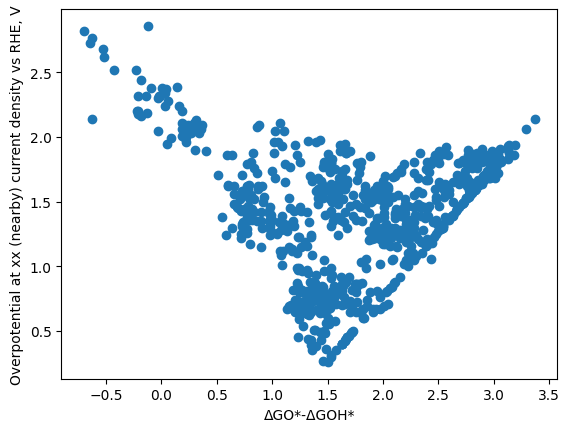

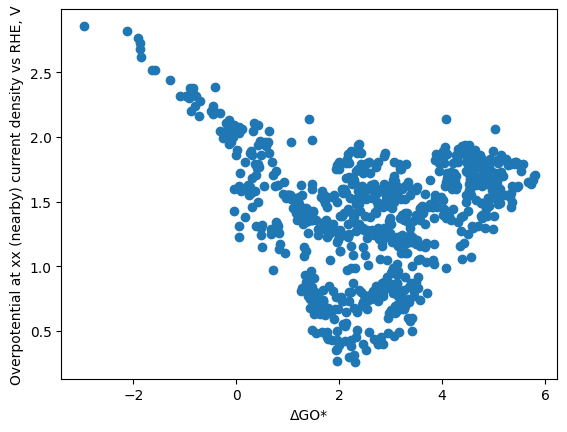

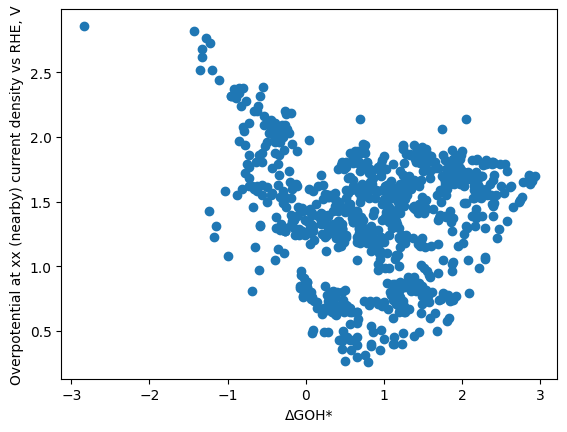

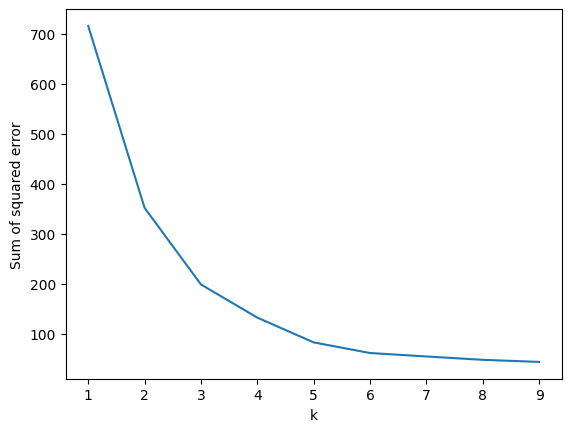

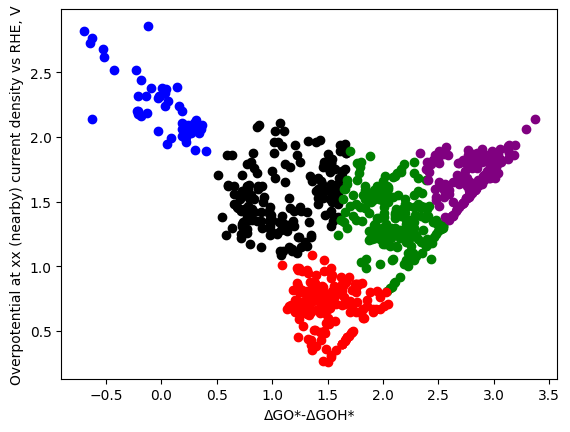

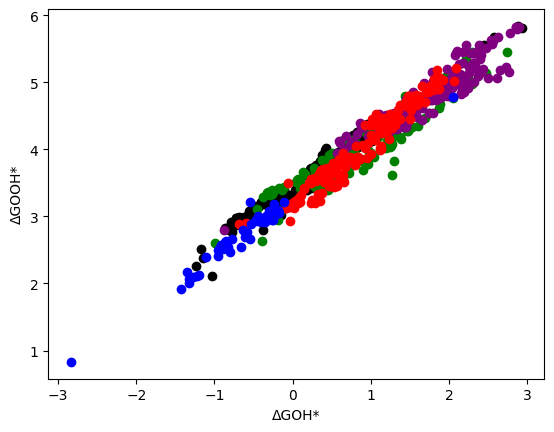

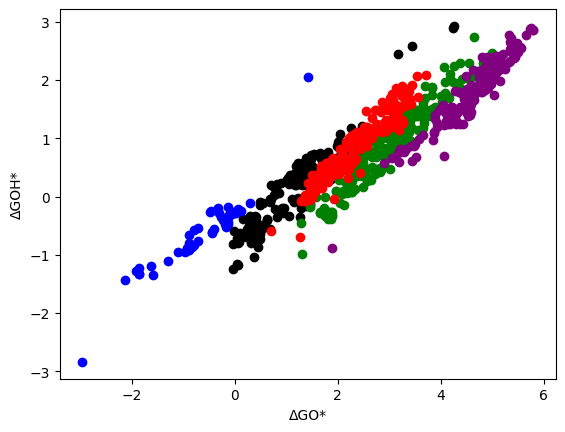

0.8164515758533752
0.5313043087091569


In [18]:
#Placing functions down
plot_scatter_entropy(entropy_data)
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
linear_regression_model(entropy_data,'ΔGOH*','ΔGOOH*')
linear_regression_model(entropy_data,'ΔGO*','ΔGOH*')

**Data exploration of optimum cluster**

In [19]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3] 
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [20]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
printing_stats_1(optimum_catalyst,entropy_data,initial_df)

The number of families in the optimum catalysts dataframe + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered initial dataframe + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial dataframe + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Tra